# Preparando o Ambiente

In [1]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
import numpy as np
from imblearn.combine import SMOTEENN

In [2]:
train_feat = pd.read_json("./../features_preprocess/features_train_hist.json")
test_feat = pd.read_json("./../features_preprocess/features_test_hist.json")
val_feat = pd.read_json("./../features_preprocess/features_validation_hist.json")

train_dataset = pd.read_csv("./../train.csv")
test_dataset = pd.read_csv("./../test.csv")

# Preparando Conjunto de Dados

In [3]:
train_feat.loc[:, "image_id"] = train_feat["filepath"].map(lambda path :  int(path.split("/")[-1].rstrip(".png")))
val_feat.loc[:, "image_id"] = val_feat["filepath"].map(lambda path :  int(path.split("/")[-1].rstrip(".png")))
test_feat.loc[:, "image_id"] = test_feat["filepath"].map(lambda path :  int(path.split("/")[-1].rstrip(".png")))

In [4]:
val_dataset = train_dataset[train_dataset.image_id.isin(val_feat.image_id)]
train_dataset_actual = train_dataset[train_dataset.image_id.isin(train_feat.image_id)]

In [5]:
test_dataset = test_dataset.merge(test_feat, on="image_id")
val_dataset = val_dataset.merge(val_feat, on="image_id")
train_dataset_actual = train_dataset_actual.merge(train_feat, on="image_id")


In [6]:
relevant_columns = ["age", "features"]
stepval = train_dataset_actual.loc[pd.notna(train_dataset_actual.age), relevant_columns].to_numpy()
train_smoteIn = np.array([np.append(np.array(elem[0]), (np.array(elem[1])))  for elem in stepval])
label = train_dataset_actual.loc[pd.notna(train_dataset_actual.age), "cancer"].to_numpy()

In [7]:
smote_enn = SMOTEENN(random_state=0, sampling_strategy="all")
train_x_resampled, train_y_resampled = smote_enn.fit_resample(train_smoteIn, label)

In [8]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(train_x_resampled)
scaled = scaler.transform(train_x_resampled)

# Treinando Modelo

In [9]:
model = RandomForestClassifier(max_depth=15, n_estimators=100, random_state=0)
model.fit(scaled, train_y_resampled)

RandomForestClassifier(max_depth=15, random_state=0)

In [10]:
relevant_columns = ["age", "features"]
stepval = val_dataset.loc[pd.notna(val_dataset.age), relevant_columns].to_numpy()
val_in = np.array([np.append(np.array(elem[0]), (np.array(elem[1])))  for elem in stepval])
label = val_dataset.loc[pd.notna(val_dataset.age), "cancer"].to_numpy()

In [11]:
scaled_val = scaler.transform(val_in)

In [12]:
val_predict = model.predict(scaled_val)

In [13]:
from sklearn.metrics import balanced_accuracy_score
balanced_accuracy_score(label, val_predict)

0.508596408552312

# Avaliando Modelo no Conjunto de Teste

In [14]:
relevant_columns = ["age", "features"]
stepval = test_dataset.loc[pd.notna(test_dataset.age), relevant_columns].to_numpy()
test_in = np.array([np.append(np.array(elem[0]), (np.array(elem[1])))  for elem in stepval])
label = test_dataset.loc[pd.notna(test_dataset.age), "cancer"].to_numpy()

In [15]:
scaled_val = scaler.transform(test_in)

In [16]:
test_predict = model.predict(scaled_val)
from sklearn.metrics import balanced_accuracy_score
balanced_accuracy_score(label, test_predict)

0.5381999318273373

Text(50.722222222222214, 0.5, 'Real')

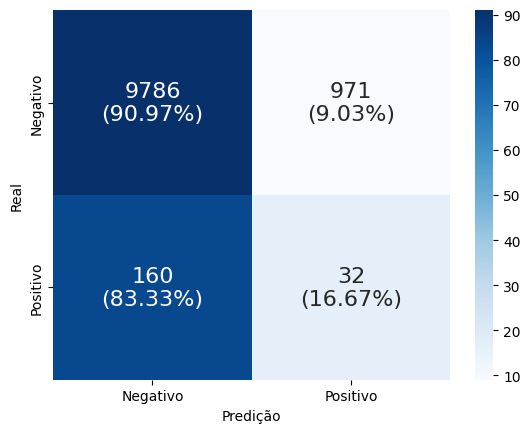

In [17]:
import seaborn as sns
import shutil
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils import class_weight

y_pred = test_predict
y_true = label

cm = confusion_matrix(y_true, y_pred)
cm_pct = confusion_matrix(y_true, y_pred, normalize = "true")

class_names = ['Negativo', 'Positivo']

ax = sns.heatmap(cm_pct*100, annot = True, fmt = '.2f', cmap = "Blues", annot_kws = {"size": 16},\
           xticklabels = class_names, yticklabels = class_names)

i=0
for t in ax.texts:
  t.set_text(str(cm.flatten()[i])+ "\n("+ t.get_text() + "%)")
  i = i+1

ax.set_xlabel("Predição")
ax.set_ylabel("Real")